# Dépenses de consommation trimestrielles des ménages

## Data Management

### Importations des packages

In [32]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
import os

%matplotlib inline

cwd = os.getcwd()

### Importation des données

In [33]:
''' Import des données '''

conso = pd.read_csv('Ressources/Consommation.csv',sep=';') 
# conso contient la variable cible à prédire

conso_fonction = pd.read_csv('Ressources/Consommation par fonction.csv',sep=';') 
# conso_fonction contient les aggrégats intermédiaires (dépenses dans l'immobilier, dans les services, etc.)

''' Élimination des lignes et des colonnes indésirables '''

conso = conso.set_index('Libellé').drop('idBank').drop('Période').drop('Codes',axis=1).astype('float64') # Pour conso
conso_fonction = conso_fonction.set_index('Libellé').drop('idBank').drop('Période').filter(like='Dépenses').astype('float64') # Pour conso_fonction

''' Simplification des noms des features '''

# Pour conso_fonction
renaming = {}
for elt in conso_fonction.columns:
    renaming[elt]=elt.lstrip('Dépense de consommation des ménages - ').rstrip('Série CVS-CJO').rstrip('Volume aux prix de l\'année précédente chaînés').rstrip(' -')
conso_fonction = conso_fonction.rename(renaming,axis='columns')

# Pour conso
conso = conso.rename({'Dépenses de consommation des ménages - Total - Volume aux prix de l\'année précédente chaînés - Série CVS-CJO':'Total'},axis='columns')

''' Séparations des comptes qui se recoupent '''

conso_durabilite = pd.DataFrame()
recoupement = ['Biens','Services','Services marchands','Solde touristique','Biens manufacturés','Biens industriels','Services non marchands']

for categorie in recoupement:
    conso_durabilite[categorie] = pd.Series(conso_fonction.pop(categorie))

### Calcul des variation de trimestre en trimestre

Par variation nous entendons: variation = (consommation du trimestre actuel/consommation du trimestre précédent) - 1

In [34]:
variations_conso_fonction = pd.DataFrame()

for column in conso_fonction.columns:
    donnees = []
    for i  in range(len(conso_fonction[column])-1):
        donnees.append(conso_fonction[column][i+1]/conso_fonction[column][i] - 1)
    variations_conso_fonction[column] = pd.Series(donnees)
    
variations_conso = pd.DataFrame()
donnees = []
for i in range(len(conso)-1):
    donnees.append(conso['Total'][i+1]/conso['Total'][i] - 1)
variations_conso['Total'] = pd.Series(donnees)

In [35]:
variations_conso_fonction = variations_conso_fonction.rename(dict(zip(range(len(conso_fonction.index)),conso_fonction.index)))
variations_conso = variations_conso.rename(dict(zip(range(len(conso.index)),conso.index)))

### Séparation des tables en différentes périodes de temps

In [82]:
date = 1990
variations_conso_1990_actu = variations_conso.loc[[int(elt[0:4])>=date for elt in variations_conso.index],:]
variations_conso_fonction_1990_actu = variations_conso_fonction.loc[[int(elt[0:4])>=date for elt in variations_conso_fonction.index],:]

Pour résumer le data management:
* conso contient la variable cible: la dépense de consommation finale des ménages trimestrielle
* conso_fonction contient les fonctions de consommation
* variations_conso contient les variations des dépenses de consommation finale, de trimestre en trimestre
* variations_conso_fonction fait de même pour les fonctions de consommation

## ACP

In [37]:
from sklearn.preprocessing import StandardScaler
X_variations_conso_fonction = StandardScaler().fit_transform(variations_conso_fonction)

pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X_variations_conso_fonction))
print(np.around(pca.explained_variance_ratio_,3))

[0.221 0.111 0.095 0.08  0.069 0.057 0.053 0.049 0.044 0.042 0.032 0.031
 0.029 0.026 0.024 0.022 0.013]


Text(0.5, 1.0, 'Variance expliquée')

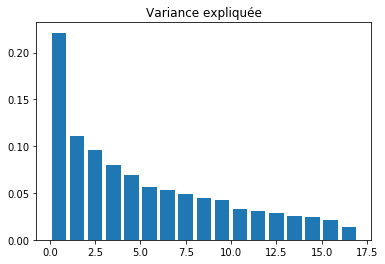

In [38]:
plt.bar(np.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée")

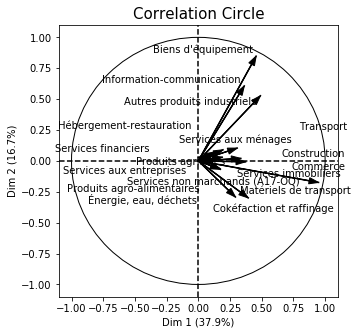

In [39]:
figure, correlation_matrix = plot_pca_correlation_graph(variations_conso_fonction, 
                                                        variations_conso_fonction.columns,
                                                        figure_axis_size=5)

In [40]:
principal_components = pd.DataFrame(pca.components_)
principal_components = principal_components.rename({i : 'PC'+str(i+1) for i in range(len(principal_components.columns))},axis=1)
principal_components = principal_components.rename(dict(zip(range(len(variations_conso_fonction.columns)),variations_conso_fonction.columns)))

In [41]:
principal_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
Produits agricoles,-0.129610,-0.213281,-0.179944,-0.251916,-0.257505,-0.368950,-0.107445,-0.272374,-0.314733,-0.229671,-0.242795,-0.251781,-0.136221,-0.195773,-0.358132,-0.221819,-0.212630
Produits agro-alimentaires,-0.260019,-0.258090,-0.018601,0.480525,0.087705,0.260205,-0.013593,-0.332222,-0.128106,0.164170,0.014929,0.492719,-0.280783,-0.161825,-0.204050,-0.104451,-0.068138
Cokéfaction et raffinage,0.121148,-0.049879,-0.436242,-0.036508,-0.112062,-0.009376,-0.573014,-0.043695,0.199457,0.017904,0.412347,0.003545,-0.038995,-0.369647,0.012199,0.164265,0.269921
Biens d'équipement,-0.067274,0.101261,0.370378,-0.289923,0.149968,-0.208861,0.278105,-0.351078,0.228320,0.092068,0.300092,-0.110360,-0.507726,-0.177843,0.004565,0.100019,0.187066
Matériels de transport,-0.632714,-0.444208,0.040606,-0.186571,0.000074,-0.138170,-0.056046,0.183893,0.011581,0.440890,0.154997,-0.114879,0.216458,0.132632,0.092282,0.036425,0.061798
Autres produits industriels,-0.034562,-0.221010,0.288411,0.183603,-0.018020,0.013550,0.188015,0.187508,0.084022,-0.341121,0.029385,-0.064135,0.298672,-0.383647,-0.180141,-0.309349,0.518762
"Énergie, eau, déchets",-0.000676,0.004163,-0.014748,0.005110,0.665833,0.019366,-0.193393,-0.022437,0.293235,0.005917,0.042445,-0.217554,0.119911,-0.175730,-0.010506,-0.410382,-0.411327
Construction,-0.082575,0.114897,0.094556,0.006531,0.150827,0.074548,0.094609,-0.133207,-0.065032,0.095620,-0.198375,-0.089867,0.376551,-0.454835,-0.218832,0.658765,-0.157065
Commerce,0.451171,-0.235123,-0.165129,-0.070609,0.336083,-0.221639,0.077222,-0.051328,-0.246033,0.455149,-0.339405,0.046299,-0.008316,-0.075242,0.101257,-0.064190,0.364829
Transport,-0.133660,0.592088,-0.011884,0.065003,-0.292385,-0.032068,0.061212,-0.032060,-0.161174,0.454846,0.051962,-0.029323,0.151924,-0.317878,0.107726,-0.404666,-0.000798


## ANOVA

In [42]:
conso_tri=pd.read_csv('Ressources/Consommation des ménages trimestrielle.csv',sep=';')

In [43]:
conso_tri=conso_tri.set_index('Période').T

In [44]:
for column in conso_tri.columns:
    for i in range(0,18,1):
        conso_tri[column][i]=conso_tri[column][i].replace(',','.')
        conso_tri[column][i]=float(conso_tri[column][i])

### Calcul du poids de chaque catégorie

In [45]:
weights = pd.DataFrame()
for column in conso_tri.columns:
    cat = []
    for i in range(0,18,1):
        cat.append(conso_tri[column][i]/conso_tri[column][17])
    weights[column]= pd.Series(cat)
weights=weights.set_index(conso_tri.index)

In [46]:
t_weights=weights.iloc[:-1,:].T
mean_weights= pd.DataFrame()
for column in t_weights.columns:
    m=[t_weights[column].mean()]
    mean_weights[column]=pd.Series(m)
mean_weights.index=['Poids moyen']

In [47]:
mean_weights.T

,Poids moyen
Produits agricoles,0.029587
"Energie, eau, déchets",0.042214
Produits agro-alimentaires,0.153231
Cokéfaction et raffinage,0.042582
Biens d'équipement,0.030978
Matériels de transport,0.062470
Autres produits industriels,0.144076
Construction,0.014645
Commerce,0.012431
Transport,0.029877


### Year to year variations

In [48]:
t_conso=conso_tri.T

In [49]:
yty_var = pd.DataFrame()
for column in t_conso.columns:
    var=[]
    for i in range(4,len(conso_tri.columns),1):
        var.append((t_conso[column][i]-t_conso[column][i-4])/t_conso[column][i-4])
    yty_var[column]=pd.Series(var)

In [50]:
yty_var=yty_var.set_index(t_conso.index.drop('1990T1').drop('1990T2').drop('1990T3').drop('1990T4')).T

### Variance des variations

In [51]:
t_yty = yty_var.iloc[:-1,:].T
variance= pd.DataFrame()
for column in t_yty.columns:
    v=[]
    s=0
    for i in range(0,len(t_yty[column]),1):
        s= s+ (t_yty[column][i]-t_yty[column].sum())**2
    v.append((1/(len(t_yty[column])))*s)
    variance[column]=pd.Series(v)
variance.index=['Variance de variation']

In [52]:
variance.T

,Variance de variation
Produits agricoles,6.978181
"Energie, eau, déchets",18.321859
Produits agro-alimentaires,8.480389
Cokéfaction et raffinage,9.814771
Biens d'équipement,6.240244
Matériels de transport,6.631205
Autres produits industriels,3.960763
Construction,17.290893
Commerce,9.917489
Transport,20.547509


### Part de la variance

In [53]:
share_of_variance=pd.DataFrame()
for column in variance.columns: 
    p=[]
    s=0
    for i in range(0,17,1):
        s=s+ variance.T['Variance de variation'][i]*mean_weights.T['Poids moyen'][i]
    p.append((variance[column][0]*mean_weights[column][0])/s)
    share_of_variance[column]=pd.Series(p)
share_of_variance.index=['Part de la variation']

In [54]:
share_of_variance.T

,Part de la variation
Produits agricoles,0.017167
"Energie, eau, déchets",0.064309
Produits agro-alimentaires,0.108046
Cokéfaction et raffinage,0.034750
Biens d'équipement,0.016073
Matériels de transport,0.034444
Autres produits industriels,0.047448
Construction,0.021056
Commerce,0.010251
Transport,0.051044


## Étude des variables officielles

### Import des données

In [55]:
os.chdir(cwd+'/Ressources')
services = pd.read_csv('Services index.csv',sep=';')
goods = pd.read_csv('Goods index.csv',sep=';')
retail_trade = pd.read_csv('Retail trade index.csv',sep=';')
os.chdir(cwd)

In [56]:
services = services.drop(range(4)).set_index('Titre :').replace(',','.',regex=True).astype('float64')
goods = goods.drop(range(4)).set_index('Titre :').replace(',','.',regex=True).astype('float64')
retail_trade = retail_trade.drop(range(4)).set_index('Titre :').replace(',','.',regex=True).astype('float64')

### Graphiques

### Régression Lasso pour déterminer les bonnes features

In [57]:
from sklearn.linear_model import Lasso
reg = Lasso()
reg.fit(retail_trade.dropna(),conso.iloc[range(len(retail_trade.dropna()))])

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
CJO_CVS = []
brut = []
for column in retail_trade.columns:
    CJO_CVS.append(column.endswith('(CJO CVS)'))
    brut.append(column.endswith('(Brut)'))

regCVO_CJS = Lasso()
regBrut = Lasso()

regCVO_CJS.fit(retail_trade[retail_trade.columns[CJO_CVS]].dropna(),conso.iloc[range(len(retail_trade[retail_trade.columns[CJO_CVS]].dropna()))])
regBrut.fit(retail_trade[retail_trade.columns[brut]].dropna(),conso.iloc[range(len(retail_trade[retail_trade.columns[brut]].dropna()))])

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [59]:
pca_retail_trade = PCA()
pca_retail_trade.fit(retail_trade[retail_trade.columns[CJO_CVS]].dropna())
print(np.around(pca.explained_variance_ratio_,3))

[0.221 0.111 0.095 0.08  0.069 0.057 0.053 0.049 0.044 0.042 0.032 0.031
 0.029 0.026 0.024 0.022 0.013]


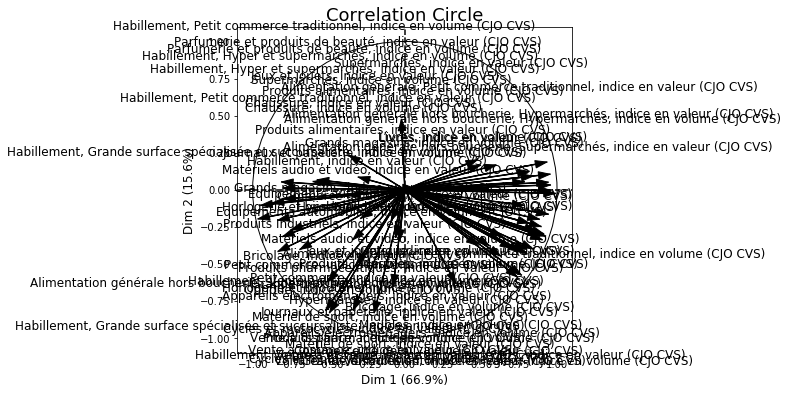

In [60]:
figure, correlation_matrix = plot_pca_correlation_graph(retail_trade[retail_trade.columns[CJO_CVS]].dropna(), 
                                                        retail_trade[retail_trade.columns[CJO_CVS]].dropna().columns)

In [61]:

pca_retail_trade.components_.shape

(66, 66)